In [ ]:
# PROJ518 - Cotton Disease Identification
# Goel Biju (10576090)

# Baseline Models

# TensorFlow version 2
# %tensorflow_version 2.x

import tensorflow as tf
print("TensorFlow version: " + tf.__version__)

# Find GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras import optimizers

import numpy as np

import cv2
from matplotlib import pyplot as plt

import os
import shutil

# Fix random seed for reproducibility
np.random.seed(42)

TensorFlow version: 2.8.2
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [ ]:
from google.colab import drive

# Importing the dataset (stored in Google Drive)
drive.mount("/content/drive", force_remount=True)

# !ls "/content/drive/MyDrive/Cotton Dataset/data"

Mounted at /content/drive


In [ ]:
# Clone the dataset from GitHub (if required)
!rm -rf Cotton-Disease-Identification

!git clone https://github.com/GoelBiju/Cotton-Disease-Identification

Cloning into 'Cotton-Disease-Identification'...
remote: Enumerating objects: 1938, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1938 (delta 3), reused 0 (delta 0), pack-reused 1927
Receiving objects: 100% (1938/1938), 1.56 GiB | 27.71 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (3777/3777), done.


In [26]:
# data_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data"
data_dir = "/content/Cotton-Disease-Identification/data"

# Model parameters
epochs = 30 # 10, 25, 50, 100
batch_size = 32 # 32, 64, 128
data_augmentation = False

In [27]:
# See the number of classes available
for image_class in os.listdir(data_dir + '/train'):
    print(image_class)

# img = cv2.imread(os.path.join(data_dir, 'healthy', 'IMG_20210927_132155_103.jpg'))
# img.shape

# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

healthy
leaf_curl


In [41]:
# Load in data
# data = tf.keras.utils.image_dataset_from_directory(data_dir)

# default batch size of 32, image size 256x256

train_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(256, 256),
    batch_size=batch_size,
    # label_mode="binary",
    seed=42)

val_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    image_size=(256, 256),
    batch_size=batch_size,
    # label_mode="binary",
    seed=42)

print(train_data.class_names)

Found 1318 files belonging to 2 classes.
Found 376 files belonging to 2 classes.
['healthy', 'leaf_curl']


(32, 256, 256, 3)
(32,)


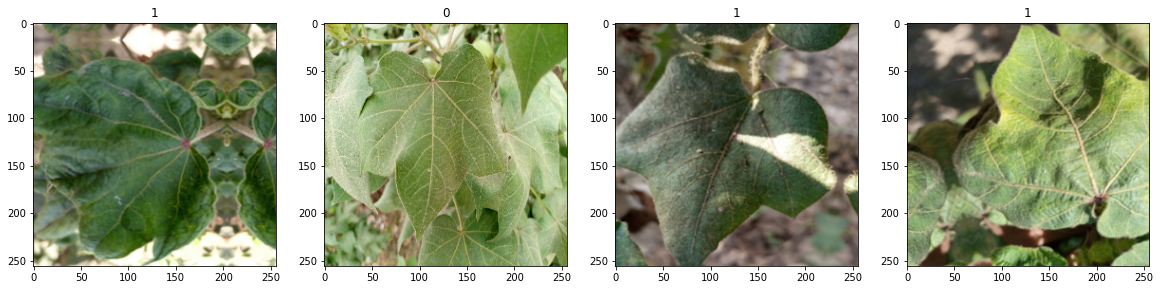

In [42]:
# Show some samples of training data
data_iterator = train_data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    

# print(train_data.cardinality().numpy())
# for i, (x, y) in enumerate(train_data):
#     print(i, x.numpy().shape, y.numpy().shape)

In [31]:
# Performance on the dataset
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
# Scale the data
# data = data.map(lambda x, y: (x / 255, y))

rescaling = tf.keras.layers.Rescaling(1./255)
normalizer = tf.keras.layers.Normalization(mean=[0.4871, 0.5598, 0.3781], variance=[np.square(0.1980), np.square(0.1862), np.square(0.1908)])

train_data = train_data.map(lambda x, y: (normalizer(rescaling(x)), y))
val_data = val_data.map(lambda x, y: (normalizer(rescaling(x)), y))


# image_batch, labels_batch = next(iter(normalized_train_data))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0, 1]`.
# print(np.min(first_image), np.max(first_image))

# train_data.as_numpy_iterator().next()

In [ ]:
# # Split Data - 70%, 20%, 10% splits for the train, validation and testing datasets
# train_size = int(len(data) * .7)
# val_size = int(len(data) * .2)
# test_size = int(len(data) * .1)

# train_size

# train = data.take(train_size)
# val = data.skip(train_size).take(val_size)
# test = data.skip(train_size + val_size).take(test_size)

# train

In [46]:
# Create the architecture for the deep learning model

# Clear any previous models created to prevent
# adding unnecessary layers when testing again
tf.keras.backend.clear_session()

# Initial model
model = Sequential()

In [ ]:
# # Model (Baseline 1) architecture
# baseline_num = 1

# model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3), 1, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(16, (3, 3), 1, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
          
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
          
# model.add(Dense(1, activation='sigmoid'))

In [47]:
# Model (Baseline 2) architecture
baseline_num = 2

# "Conv1" - filter size = 5x5, # of filter = 192, pad = 2, stride = 1, Act. = ReLU
model.add(Conv2D(192, kernel_size=(5, 5), activation='relu', strides=1, input_shape=(256, 256, 3)))
# Zero padding is applied to following layers
model.add(ZeroPadding2D(padding=2))
# "mlp 1" - filter size = 1x1, # of filter = 160, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(160, activation='relu'))
# "mlp 2" - filter size = 1x1, # of filter = 96, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(96, activation='relu'))
# "Pool 1" - 3x3 max pooling, stride = 2
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# Dropout 0.5
model.add(Dropout(0.5))


# "Conv2" - filter size = 5x5, # of filter = 192, pad = 2, stride = 1, Act. = ReLU
model.add(Conv2D(192, kernel_size=(5, 5), activation='relu', strides=1))
# Zero padding is applied to following layers
model.add(ZeroPadding2D(padding=2))
# "mlp 2-1" - filter size = 1x1, # of filter = 160, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(192, activation='relu'))
# "mlp 2-2" - filter size = 1x1, # of filter = 96, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(192, activation='relu'))
# "Pool 2" - 3x3 max pooling, stride = 2
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
# Dropout 0.5
model.add(Dropout(0.5))


# "Conv3" - filter size = 3x3, # of filter = 192, pad = 1, stride = 1, Act. = ReLU
model.add(Conv2D(192, kernel_size=(3, 3), activation='relu', strides=1))
# Zero padding is applied to following layers
model.add(ZeroPadding2D(padding=1))

# Flatten operation?

# "mlp 3-1" - filter size = 1x1, # of filter = 192, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(192, activation='relu'))

# "mlp 3-2" - filter size = 1x1, # of filter = 10, pad = 0, stride = 1, Act. = ReLU
model.add(Dense(10, activation='relu'))
# "Global Pool" - Average Pooling
model.add(GlobalAveragePooling2D())

# "Sigmoid" - Add softmax activation function
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
# # Model (Baseline 3) architecture
# baseline_num = 3

# # Convolution layer 1 and pooling
# model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(256, 256, 3))) # 1 for padding
# model.add(MaxPooling2D(pool_size=2, strides=2))

# # Convolution layer 2 and pooling
# model.add(Conv2D(32, (3, 3), padding="same", activation='relu')) # 1 for padding
# model.add(MaxPooling2D(pool_size=2, strides=2))

# # Flattening
# model.add(Flatten())

# # Full connection
# model.add(Dense(128, activation='relu')) # 256?

# # Output layer
# model.add(Dense(1, activation='sigmoid'))

In [48]:
# Compile the model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])


# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 192)     14592     
                                                                 
 zero_padding2d (ZeroPadding  (None, 256, 256, 192)    0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 256, 256, 160)     30880     
                                                                 
 dense_1 (Dense)             (None, 256, 256, 96)      15456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 96)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 96)      0

In [49]:
# Train the model
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
# STEP_SIZE_VALID = valid_data.n // valid_data.batch_size

# TODO: Steps per epoch for training and validation
hist = model.fit(train_data,
                 # steps_per_epoch=STEP_SIZE_TRAIN,
                 validation_data=val_data,
                 # validation_steps=STEP_SIZE_VALID,
                #  validation_steps=10,
                 epochs=epochs,
                 callbacks=[tensorboard_callback])

Epoch 1/30
42/42 [==============================] - 29s 619ms/step - loss: 0.6951 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4947
Epoch 2/30
42/42 [==============================] - 28s 622ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 3/30
42/42 [==============================] - 28s 614ms/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 4/30
42/42 [==============================] - 28s 618ms/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 5/30
42/42 [==============================] - 28s 613ms/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 6/30
42/42 [==============================] - 28s 614ms/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 7/30
32/42 [=====================>........] - ETA: 5s - loss: 0.6931 - accuracy: 0.5107

KeyboardInterrupt: ignored

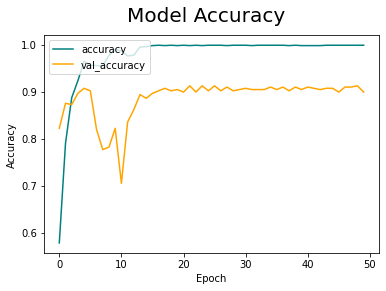

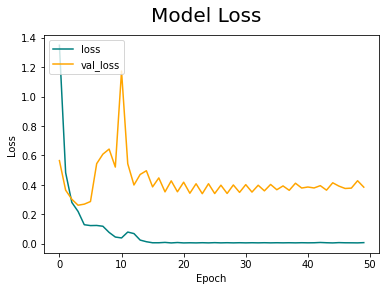

In [ ]:
# Plot accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Model Accuracy', fontsize=20)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()


# Plot loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Model Loss', fontsize=20)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()


In [ ]:
# # Evaluate
# pre = Precision()
# re = Recall()
# acc = BinaryAccuracy()

# for batch in test.as_numpy_iterator(): 
#     X, y = batch
#     yhat = model.predict(X)
#     pre.update_state(y, yhat)
#     re.update_state(y, yhat)
#     acc.update_state(y, yhat)

# print(pre.result(), re.result(), acc.result())

In [ ]:
# Load and test the saved model
test_model = load_model("/content/drive/MyDrive/PROJ518/models/baseline/proj518_baseline_3-e25-bs128-da-false.h5")

# Prediction on test dataset
test_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data/val"

# IMG_20210929_131745_393.jpg (healthy)
# IMG_20211008_134111_814.jpg, IMG_20211008_134152_686 (leaf curl)
image_path = os.path.join(test_dir, 'leaf_curl', 'IMG_20211004_160551_293.jpg')
print(image_path)

img = cv2.imread(image_path)
img.shape
# plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

if yhat > 0.5: 
    print(f'Predicted class is leaf curl virus')
else:
    print(f'Predicted class is healthy leaf')

In [ ]:
# Load and test the saved model
test_model = load_model("/content/drive/MyDrive/PROJ518/models/baseline/proj518_baseline_2-e25-bs128-da-false.h5")

# Predictions on test datasets
test_lc_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data/val/leaf_curl"
test_healthy_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data/val/healthy"

test_outside_dir = "/content/drive/MyDrive/experiments/cotton/curl_virus"


# Loop through all the leaf curl images
correct = 0
files = os.listdir(test_lc_dir)
total = len(files)
for image_name in files:
  # print(image_name)

  # Get image path
  image_path = os.path.join(test_lc_dir, image_name)
  print(image_path)

  # Open the image
  img = cv2.imread(image_path)

  # Resize the image
  resize = tf.image.resize(img, (256, 256))

  yhat = test_model.predict(np.expand_dims(resize / 255, 0))
  print(yhat)

  if yhat > 0.5: 
      print(f'Predicted class is leaf curl')
      correct += 1


# # Loop through all the healthy images
# correct = 0
# healthy_files = os.listdir(test_healthy_dir)
# total = len(healthy_files)
# for image_name in healthy_files:
#   # print(image_name)

#   # Get image path
#   image_path = os.path.join(test_healthy_dir, image_name)
#   print(image_path)

#   # Open the image
#   img = cv2.imread(image_path)

#   # Resize the image
#   resize = tf.image.resize(img, (256, 256))

#   yhat = test_model.predict(np.expand_dims(resize / 255, 0))
#   print(yhat)


#   if yhat > 0.5: 
#       print(f'Predicted class is healthy leaf')
#       correct += 1

print("Correctly predicted: {0}/{1} - {2}%".format(correct, total, ((correct / total) * 100)))

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(256, 256),
    batch_size=batch_size,
    # label_mode="binary",
    seed=42)


In [ ]:
# Save the model

# Model save variables
save_dir = "/content/drive/MyDrive/PROJ518/models/baseline/"
# save_dir = "/notebooks/models/baseline/"

model_name = 'proj518_baseline_{0}-e{1}-bs{2}-da-{3}-combined'.format(baseline_num,
                                                            epochs,
                                                            batch_size if batch_size else "NA", 
                                                            str(data_augmentation).lower())

print("Saving as: ", save_dir + model_name)
model.save(os.path.join(save_dir, model_name))

Saving as:  /content/drive/MyDrive/PROJ518/models/baseline/proj518_baseline_3-e50-bs32-da-false-combined


In [ ]:
# Unmount the drive
drive.flush_and_unmount()